In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1.
Para los siguientes modelos vistos en los temas anteriores realizá pruebas:

### a.
``cs_nh`` una prueba predictiva a priori, todos los grupos juntos


In [64]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [65]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample_prior_predictive(samples=100)

Sampling: [y, μ, σ]


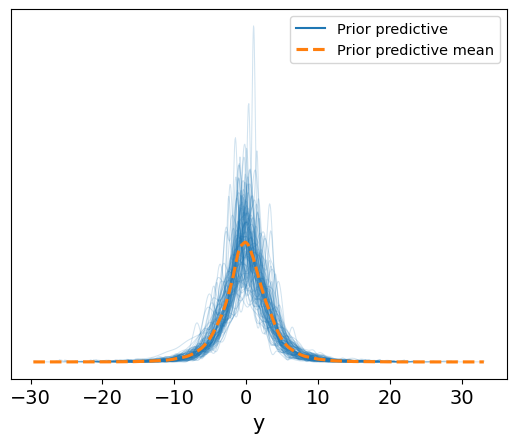

In [69]:
az.plot_ppc(idata, group="prior", kind="kde");

Los datos generados sólo con los priors parecen ser plausibles. Pero podría ver que pasa si los hago menos informativos.

Sampling: [y, μ, σ]


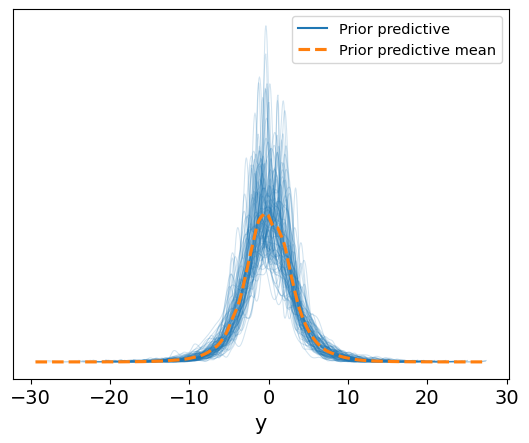

In [70]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=2, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=3, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample_prior_predictive(samples=100)
az.plot_ppc(idata, group="prior", kind="kde");

A pesar de no saber nada sobre desplazamientos quimicos supongo, al ver la data, que una differencia de 10 deberia ser casi imposible y, por lo tanto, debería volver a usar los priors de antes.  
Si tuviera conocimiento en el area no debería ver los datos para saber si una diferencia es absurda o imposible, podría usar valores de referencia.

### b. 
``cs_nh`` una prueba predictiva a posteriori, todos los grupos juntos

In [71]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


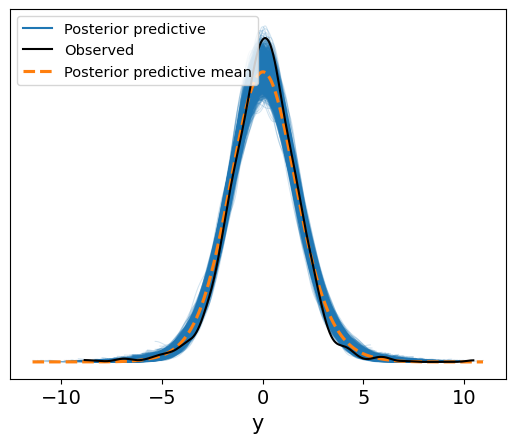

In [72]:
az.plot_ppc(idata);

Es casi identica.

### c.
``cs_nh`` una prueba predictiva a posteriori, los 19 grupos por separado

In [74]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories, "aa_flat": cat_encode.categories[idx]}

In [75]:
with pm.Model(coords=coords) as cs_nh:
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa")
    σ = pm.HalfNormal('σ', sigma=2, dims="aa")

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff, dims="aa_flat")
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

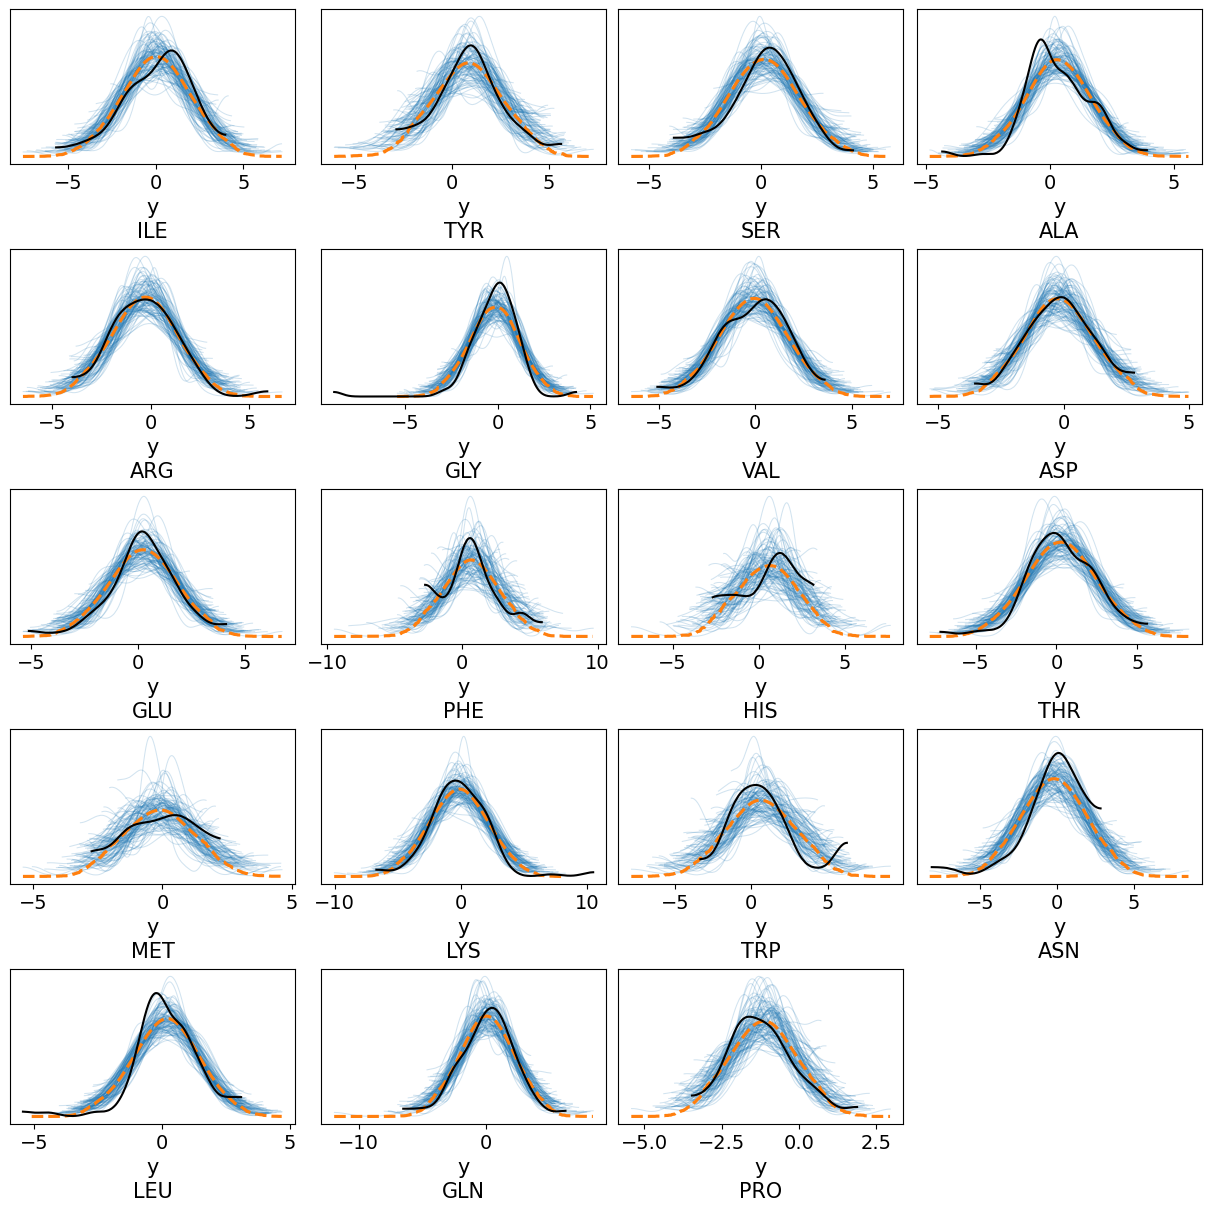

In [15]:
fig, ax = plt.subplots(5, 4, figsize=(12, 12), constrained_layout=True)
fig.delaxes(ax.flatten()[-1])
ax = ax.flatten()[:19]
az.plot_ppc(
    idata,
    coords = {"aa_flat": [cat_encode.categories]},
    flatten=[],
    num_pp_samples=100,
    ax=ax,
    legend=False,
);

Parece que, salvo para un par de grupos, el modelo predice bien los datos observados.

## 2. 
Usando un modelo construido para tus propios datos realizá una prueba predictiva a priori y en función del resultado modificá los priors elegidos.

In [27]:
url = "https://github.com/nazarenomm/Estadistica-e-Inferencia-2/raw/main/datos/Salary%20Data.csv"
df = pd.read_csv(url)
df.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


In [58]:
df.Salary.describe()

count        30.000000
mean      76003.000000
std       27414.429785
min       37731.000000
25%       56720.750000
50%       65237.000000
75%      100544.750000
max      122391.000000
Name: Salary, dtype: float64

In [60]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    mu = alpha + beta * df.YearsExperience
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df.Salary)

    idata = pm.sample_prior_predictive()

Sampling: [alpha, beta, sigma, y]


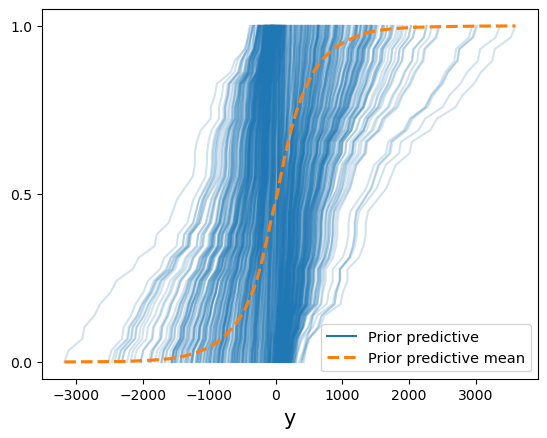

In [61]:
az.plot_ppc(idata, group="prior", kind="cumulative");

Hay salarios negativos, los valores son muy bajos en general (el minimo en el dataset es 37731)

In [62]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=10_000, sigma=100)
    beta = pm.Normal('beta', mu=10_000, sigma=100)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    mu = alpha + beta * df.YearsExperience
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df.Salary)

    idata = pm.sample_prior_predictive()

Sampling: [alpha, beta, sigma, y]


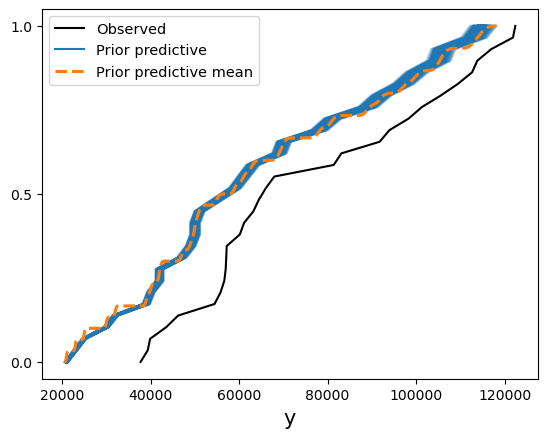

In [63]:
az.plot_ppc(idata, group="prior", kind="cumulative", observed=True);

## 3.
Usando la función ``az.plot_bpv`` y sobre la distribución a posteriori del modelo ``cs_nh`` realizá:

In [76]:
with pm.Model(coords=coords) as cs_nh:
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa")
    σ = pm.HalfNormal('σ', sigma=2, dims="aa")

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff, dims="aa_flat")
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

### a.
Un gráfico de los p-valores marginales, para todos los grupos juntos.

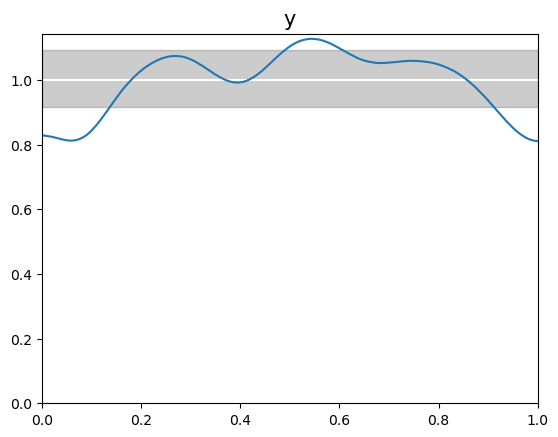

In [77]:
az.plot_bpv(idata);

Parece que en las colas hay un problema, la distribución predictiva debe estar por encima de la observada en esas zonas.

### b.
Un gráfico de los p-valores marginales, para los 19 grupos por separado.

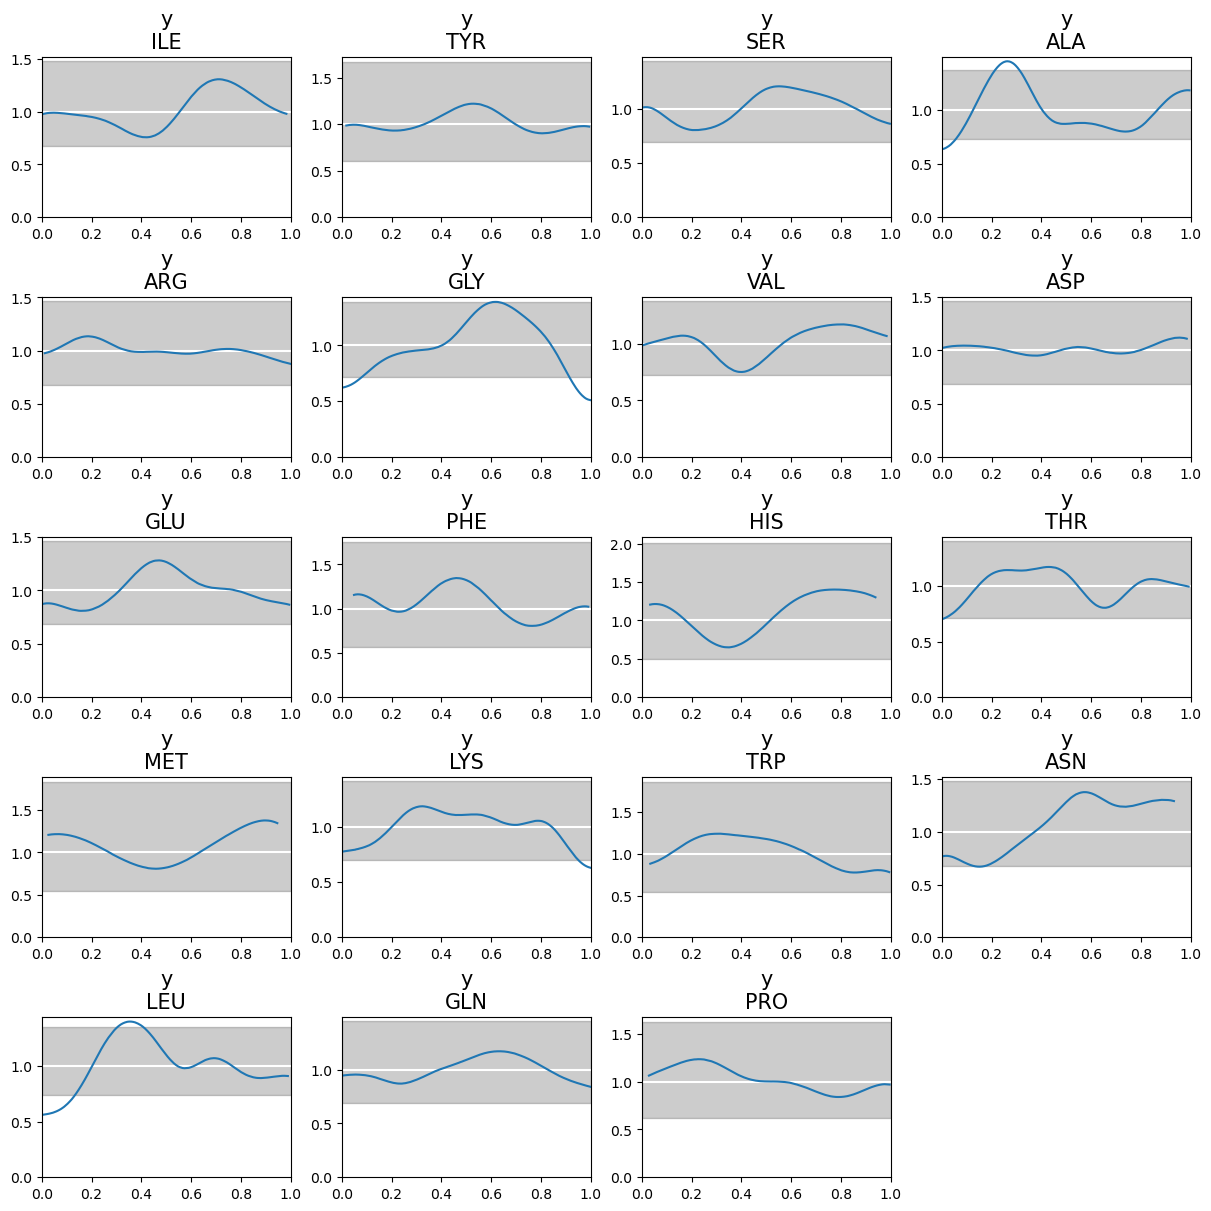

In [78]:
fig, ax = plt.subplots(5, 4, figsize=(12, 12), constrained_layout=True)
fig.delaxes(ax.flatten()[-1])
ax = ax.flatten()[:19]
az.plot_bpv(
    idata,
    coords = {"aa_flat": [cat_encode.categories]},
    ax=ax,
    flatten=[]
);

### c. 
Un gráfico de los p-valores para un estadístico a su elección que no sea la media, para los 19 grupos por separado.

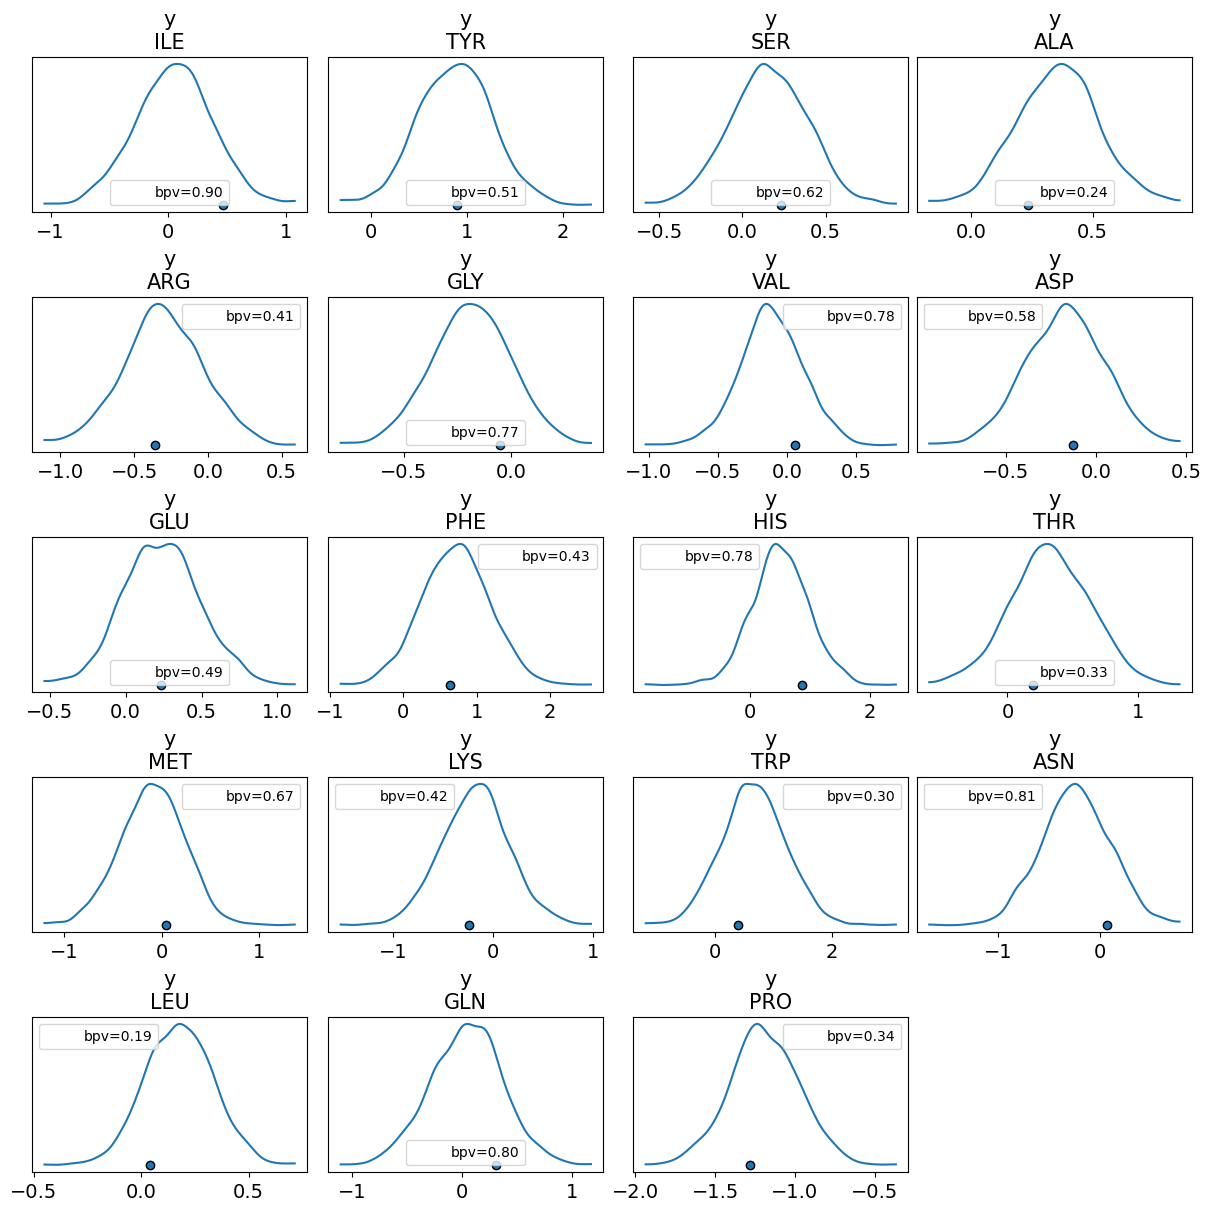

In [21]:
fig, ax = plt.subplots(5, 4, figsize=(12, 12), constrained_layout=True)
fig.delaxes(ax.flatten()[-1])
ax = ax.flatten()[:19]
az.plot_bpv(
    idata,
    kind="t_stat",
    t_stat="median",
    coords = {"aa_flat": [cat_encode.categories]},
    ax=ax,
    flatten=[]
);

Estamos bastante lejos del valor ideal (0.5) en la mayoría de los grupos.

# 4.
Para ganar intuición sobre los gráficos de p-valores marginales. Vamos a hacer el siguiente experimento. Vamos a crear 4 InferenceData, todos con el mismo grupo "observed_data" y con 200 observaciones (extra, podés probar cambiar el número de observaciones).
+ Uno de ellos con predicciones que provengan de una distribución más ancha que la observada
+ Otro con una predicciones que provengan de una distribución más angosta
+ El tercero con la media desplazada respecto de la observada
+ El cuarto con muestra de la misma distribución que la observada.

Explicá las observaciones.

In [79]:
observed_data = np.random.normal(0, 1, 1000)

In [80]:
with pm.Model() as modelo_ancho:
    μ = pm.Normal('μ', mu=0, sigma=0.1)
    y = pm.Normal('y', mu=μ, sigma=2, observed=observed_data)
    idata_ancho = pm.sample(200)
    idata_ancho.extend(pm.sample_posterior_predictive(idata_ancho))

with pm.Model() as modelo_angosto:
    μ = pm.Normal('μ', mu=0, sigma=0.1)
    y = pm.Normal('y', mu=μ, sigma=0.5, observed=observed_data)
    idata_angosto = pm.sample(200)
    idata_angosto.extend(pm.sample_posterior_predictive(idata_angosto))

with pm.Model() as modelo_desplazado:
    μ = pm.Normal('μ', mu=5, sigma=0.1)
    y = pm.Normal('y', mu=μ, sigma=1, observed=observed_data)
    idata_desplazado = pm.sample(200)
    idata_desplazado.extend(pm.sample_posterior_predictive(idata_desplazado))

with pm.Model() as modelo_obs:
    μ = pm.Normal('μ', mu=0, sigma=0.1)
    y = pm.Normal('y', mu=μ, sigma=1, observed=observed_data)
    idata_obs = pm.sample(200)
    idata_obs.extend(pm.sample_posterior_predictive(idata_obs))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]


Output()

Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]


Output()

Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]


Output()

Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]


Output()

Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Voy a graficar las posterior predictive checks para ver si encuentro una relación entre los gráficos.

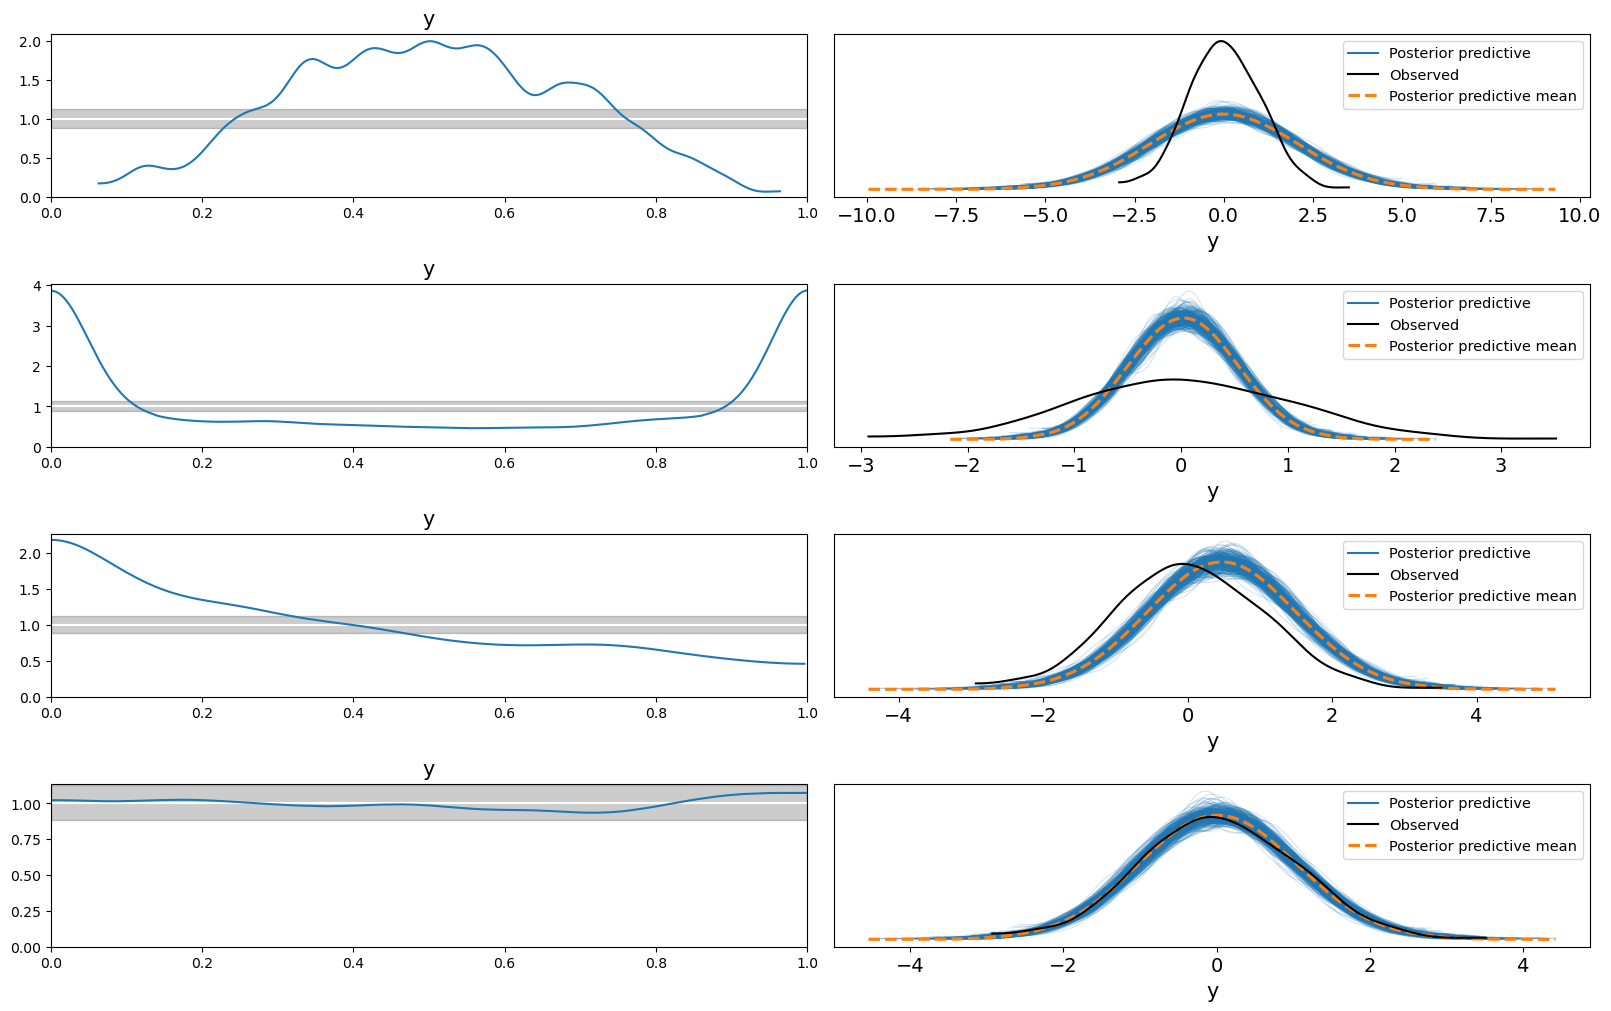

In [81]:
fig, ax = plt.subplots(4,2, constrained_layout=True, figsize= (16,10))
az.plot_bpv(idata_ancho, ax=ax[0, 0])
az.plot_ppc(idata_ancho, ax=ax[0, 1])
az.plot_bpv(idata_angosto, ax=ax[1, 0])
az.plot_ppc(idata_angosto, ax=ax[1, 1])
az.plot_bpv(idata_desplazado, ax=ax[2, 0])
az.plot_ppc(idata_desplazado, ax=ax[2, 1])
az.plot_bpv(idata_obs, ax=ax[3, 0])
az.plot_ppc(idata_obs, ax=ax[3, 1]);

+ Primer gráfico: las predicciones vienen de una distribución más ancha que la observada, llevando a valores generalmente mayores que los observados en las colas y menores en el seno de la distribución.
+ Segundo gráfico: las predicciones provienen de una distribución más angosta a la observada, ocurre lo contrario a lo anterior, la probabilidad de que las predicciones sean menores a las observaciones es menor en el centro y mayor en las colas.
+ Tercer gráfico: cuando la distribucion observada esta por encima de la _posterior predictive_ la probabilidad de que el dato predicho sea menor a un dato observado es mayor, y cuando la observada esta por debajo ocurre lo contrario. 
+  Cuarto gráfico: las predicciones provienen de una distribución similaar a la observada, causando buenos resultados. 

# Bayes Factors vs LOO (PSIS-LOO-CV)

Algunas de las diferencias de estas formas de comparar modelos son:
+ Los factores de Bayes comparan los modelos basándose en que tan bien explican los datos observados, mientras que LOO evalua su exactitud predictiva.
+ BF depede mucho más de los _priors_ elegidos ya que usa el calculo de la _likelihood marginal_.
+ BF tiene un costo computacional generalmente alto por tener que calcular integrales o SMC.
+ Calculando BF solo sabremos que modelo es mejor mientras que al calcular LOO con pymc obtenemos más información, como el error estandar, una aproximación del número efectivo de parámetros, etc.

# Diagnostico del modelo de las propinas

In [11]:
tips = pd.read_csv("../datos/propinas.csv")
categories = np.array(["Jue", "Vie", "Sab", "Dom"])

tip = tips["propina"].values
idx = pd.Categorical(tips["dia"], categories=categories).codes

In [16]:
coords = {"dias": categories, "dias_flat": categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="dias")
    σ = pm.HalfNormal("σ", sigma=1, dims="dias")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="dias_flat")

    idata_cg = pm.sample(chains=4)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Sampling: [y]


Output()

### Trace plot

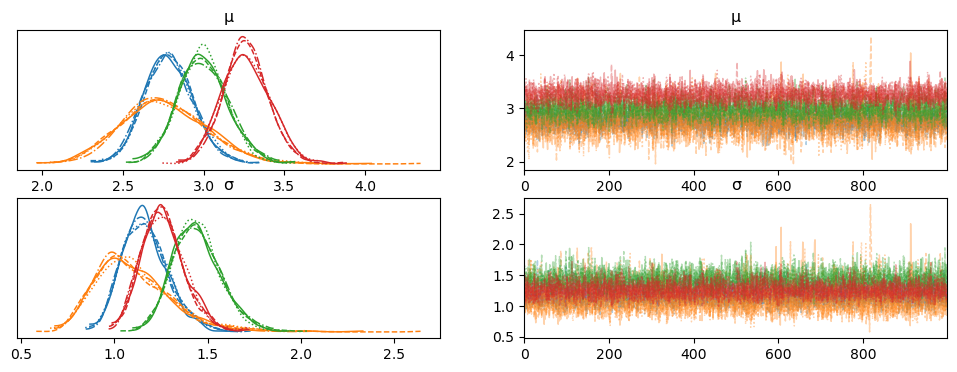

In [17]:
az.plot_trace(idata_cg);

Ninguna traza muetra un corportamiento extraño, ninguna se desvía.

### Rank Plot

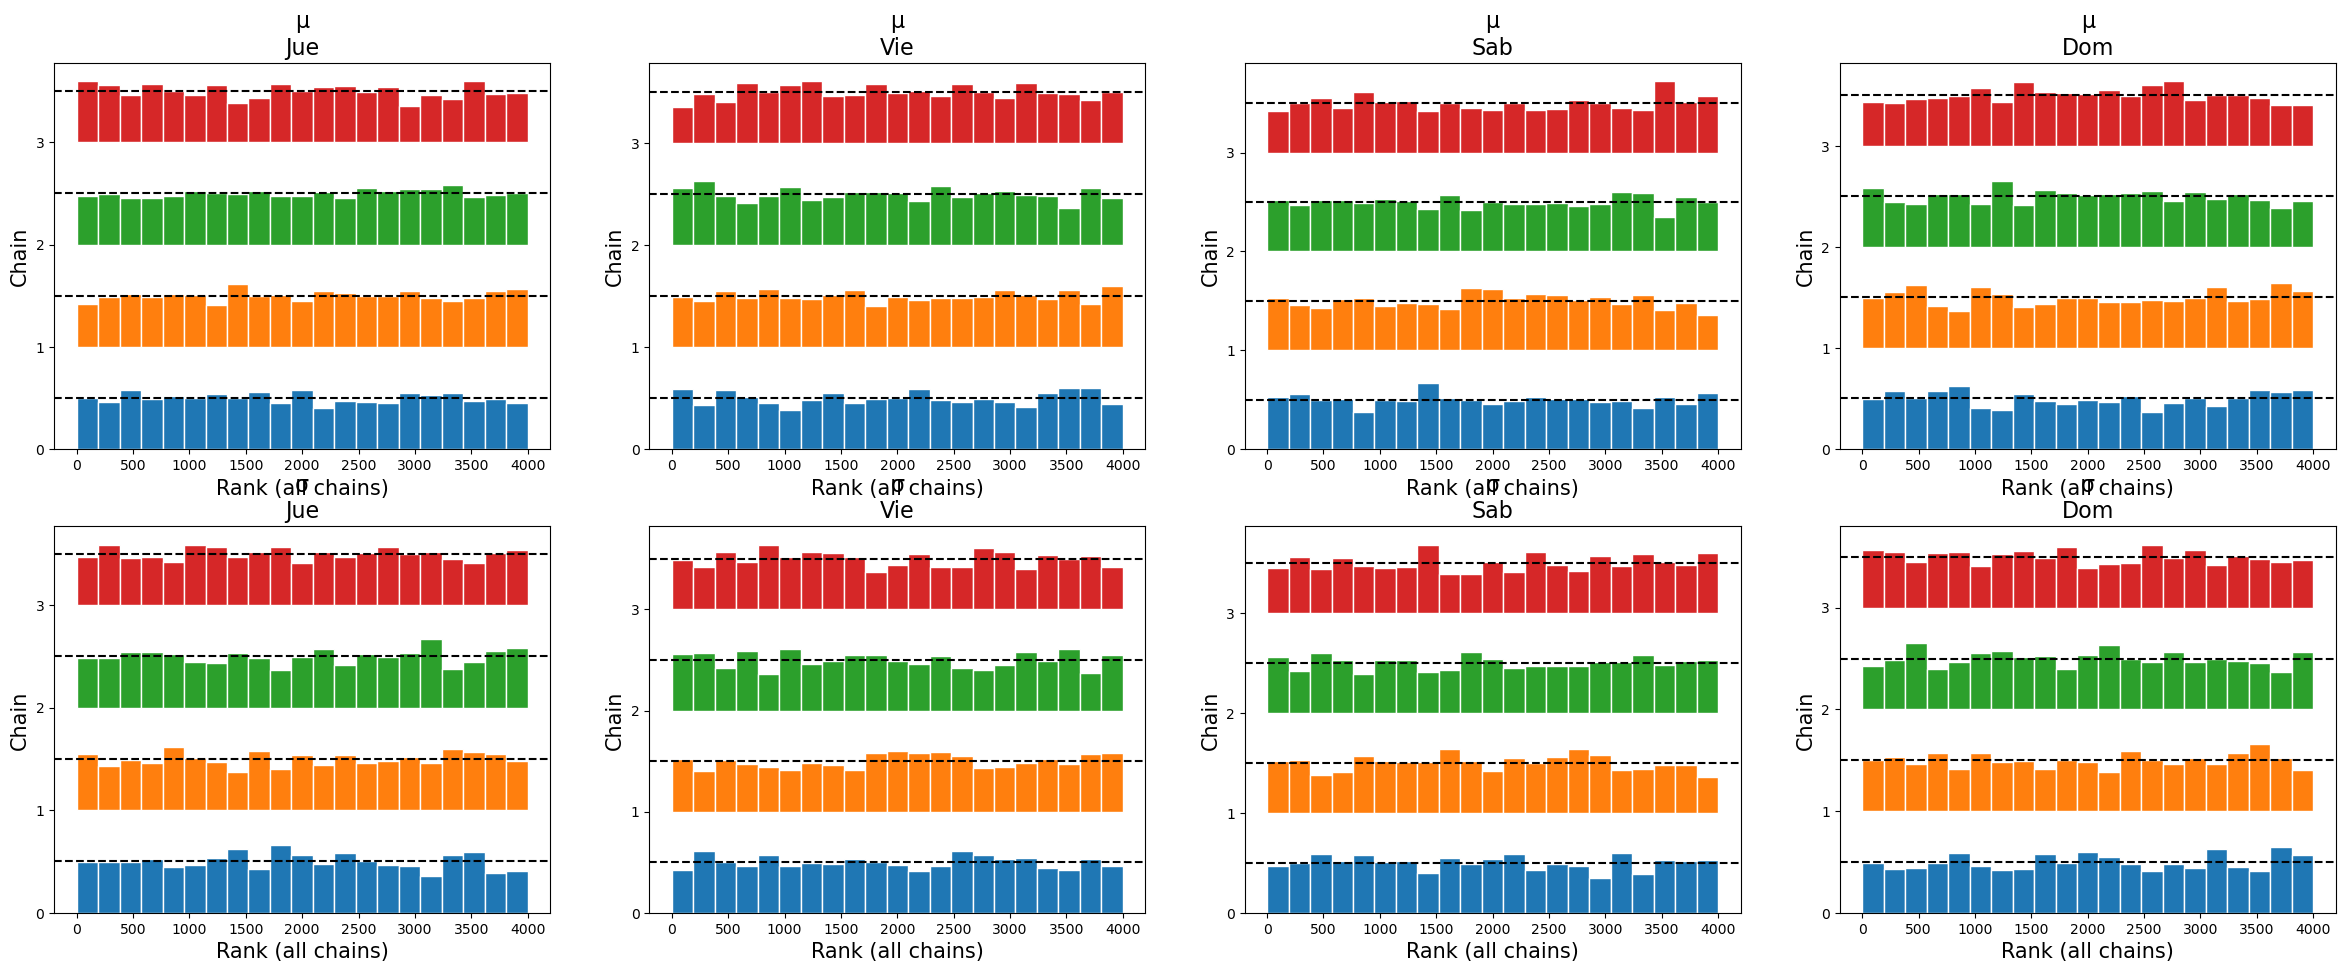

In [18]:
az.plot_rank(idata_cg);

Se asemejan a una uniforme, no parece haber problemas acá.

### $\hat{R}$

In [19]:
az.rhat(idata_cg)

<xarray.Dataset>
Dimensions:  (dias: 4)
Coordinates:
  * dias     (dias) <U3 'Jue' 'Vie' 'Sab' 'Dom'
Data variables:
    μ        (dias) float64 1.001 1.0 1.003 1.002
    σ        (dias) float64 1.001 0.9999 1.001 0.9997

Los $\hat{R}$ son menores a $1.01$, se los puede considerar seguros.

### Gráfico de autocorrelación

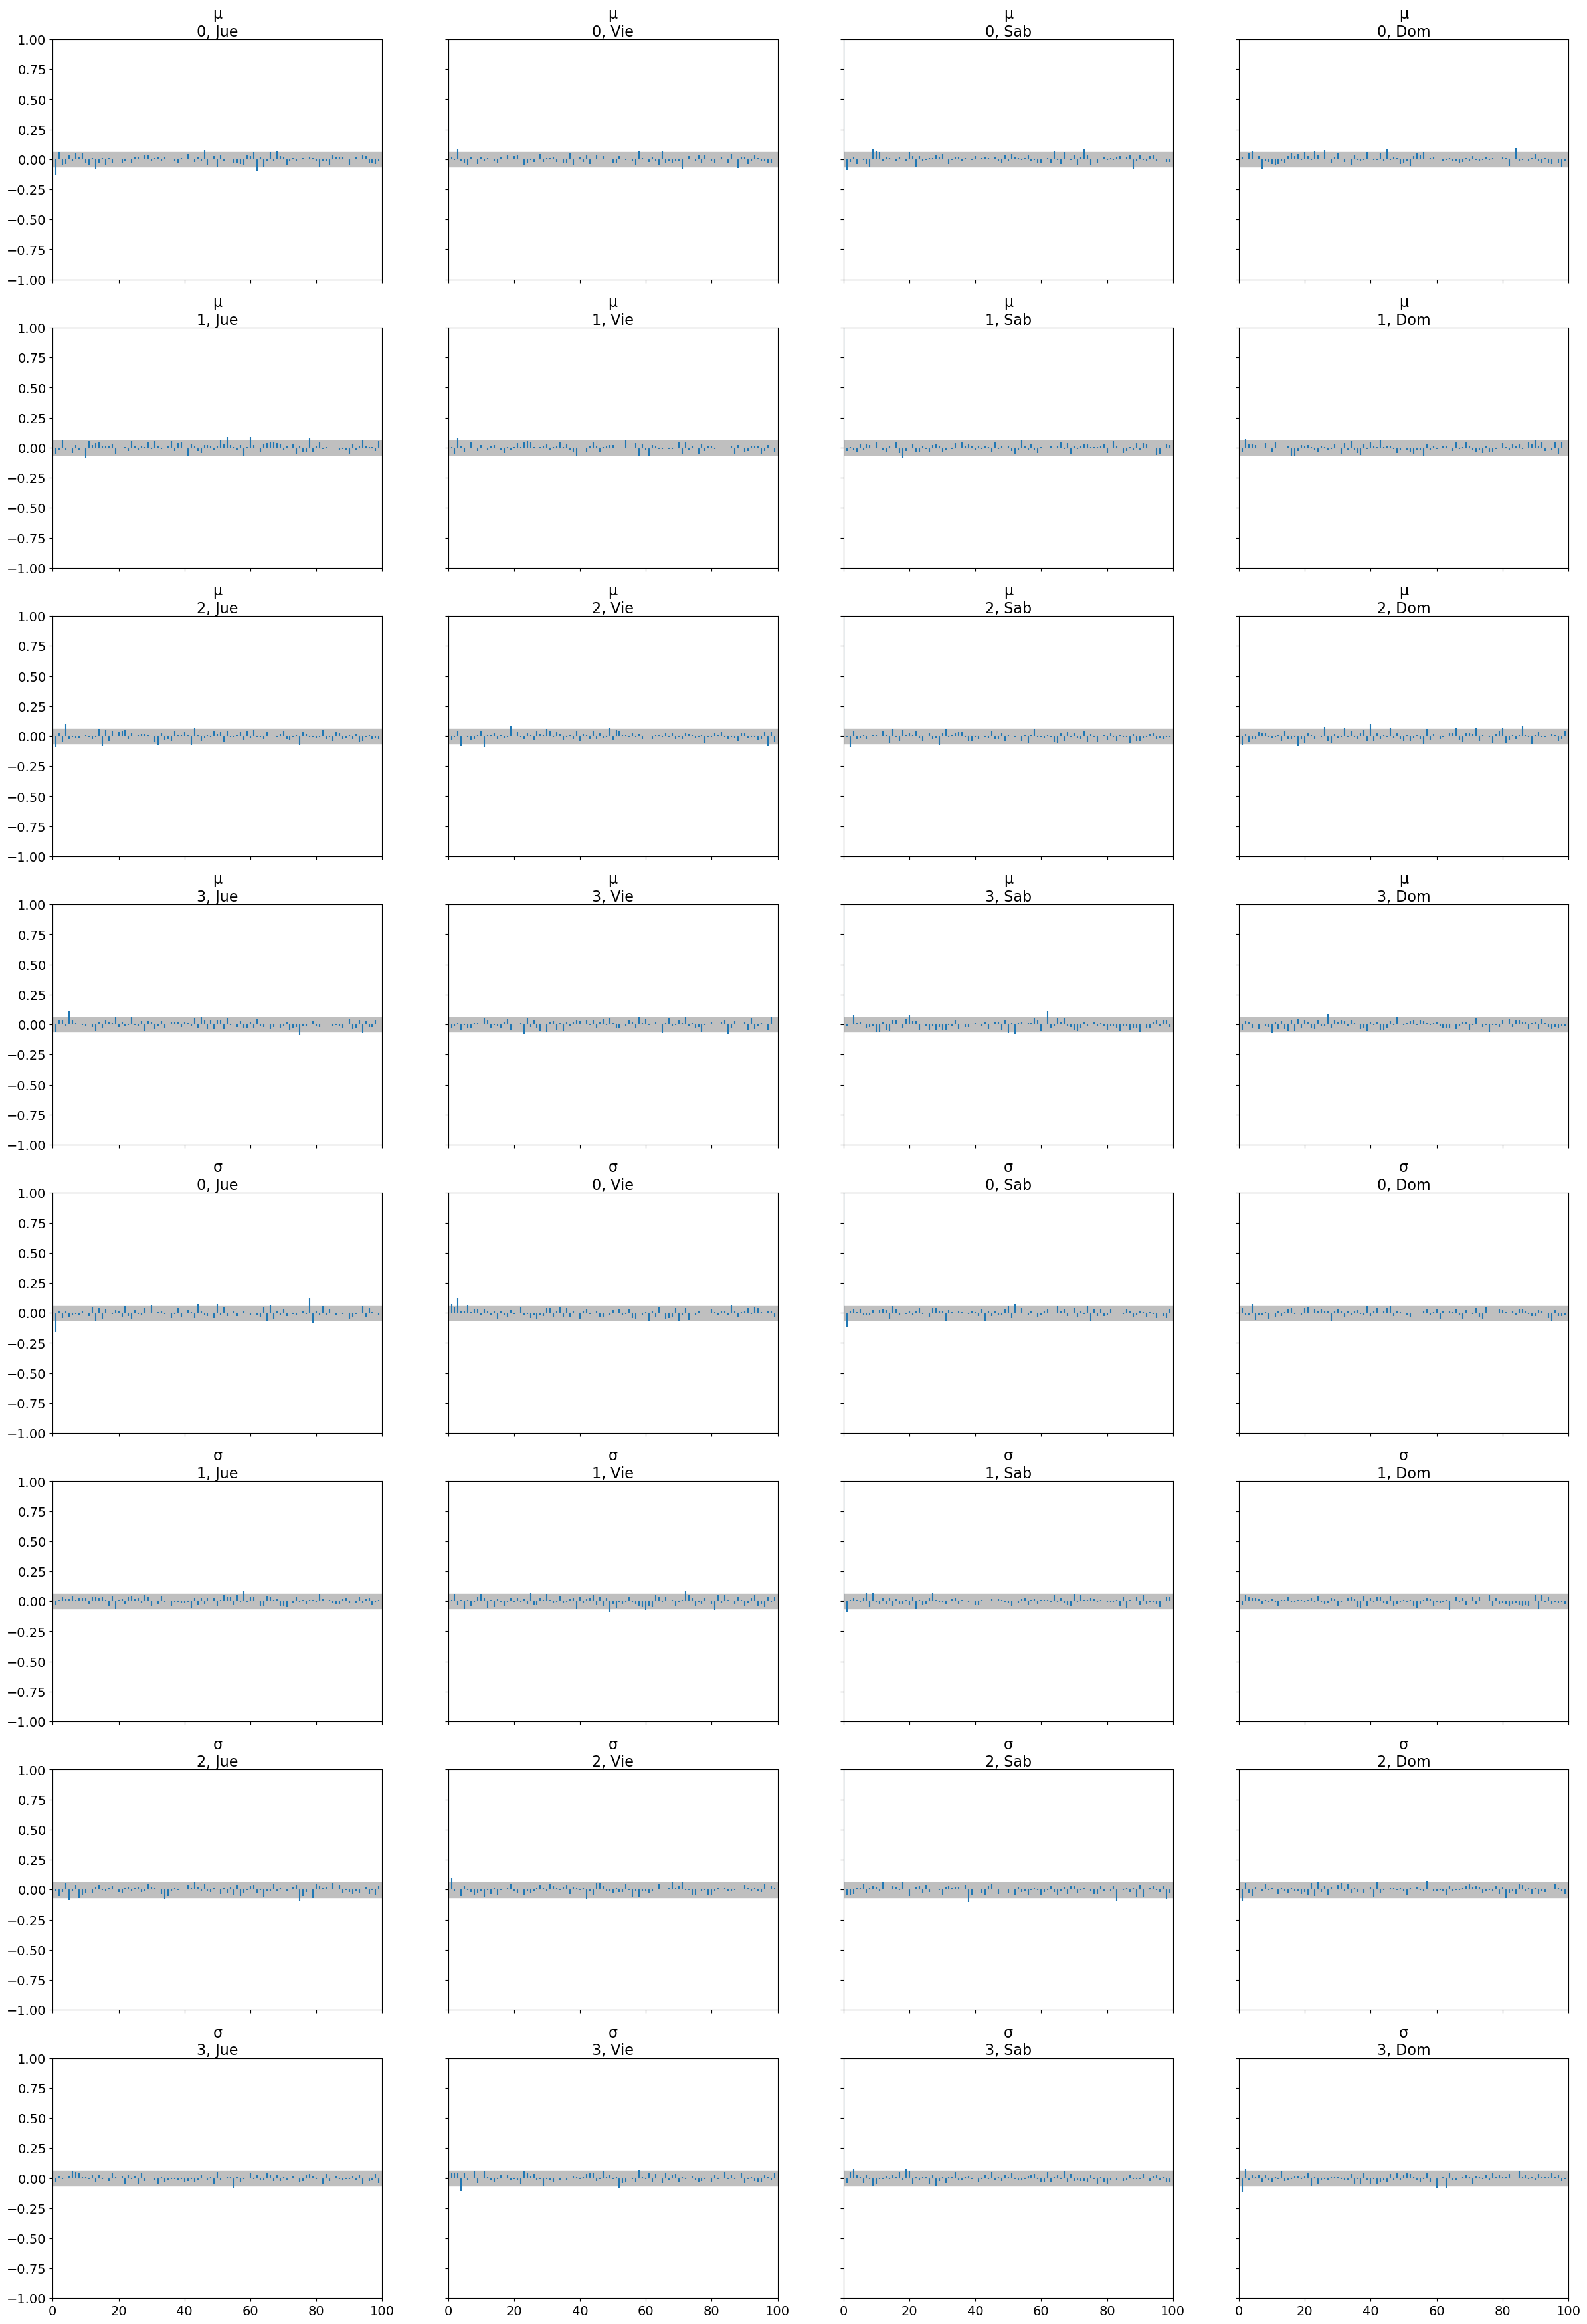

In [20]:
az.plot_autocorr(idata_cg);

Los gráficos muestran que las cadenas son adecuadas

### ESS

In [21]:
az.ess(idata_cg)

<xarray.Dataset>
Dimensions:  (dias: 4)
Coordinates:
  * dias     (dias) <U3 'Jue' 'Vie' 'Sab' 'Dom'
Data variables:
    μ        (dias) float64 4.192e+03 4.112e+03 4.323e+03 3.854e+03
    σ        (dias) float64 4.733e+03 3.842e+03 4.197e+03 4.071e+03

Alrededor de 4000 ESS por cadena, lo que sugiere que el muestreo es adecuado.

Summary

In [23]:
az.summary(idata_cg, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[Jue],0.002,0.002,4192.0,2877.0,1.0
μ[Vie],0.004,0.003,4112.0,2519.0,1.0
μ[Sab],0.002,0.002,4323.0,2982.0,1.0
μ[Dom],0.002,0.002,3854.0,2851.0,1.0
σ[Jue],0.002,0.001,4733.0,3215.0,1.0
σ[Vie],0.004,0.003,3842.0,2773.0,1.0
σ[Sab],0.002,0.001,4197.0,3307.0,1.0
σ[Dom],0.002,0.001,4071.0,3284.0,1.0
